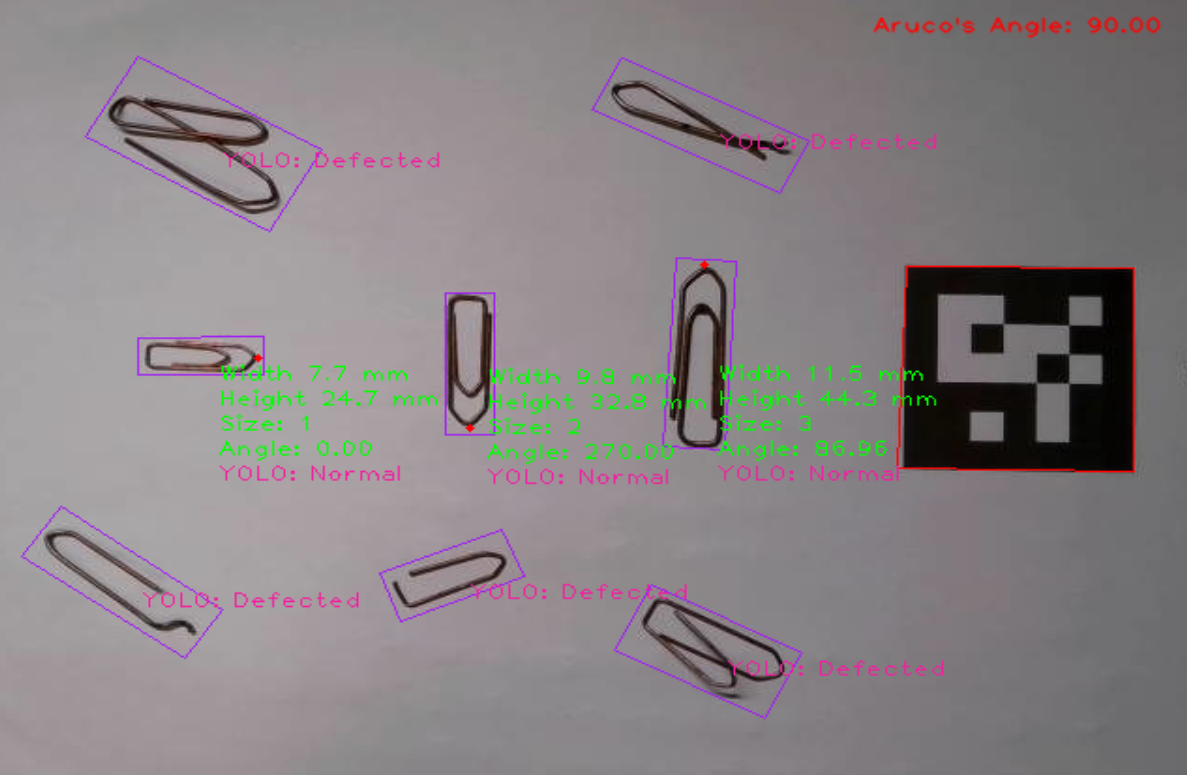

# **Analyzing Paper Clips Using Deep Learning and Computer Vision Techniques**

In this project, a combination of object detection and computer vision methods was utilized to inspect paper clips for defects. For normal clips, additional steps were taken to extract physical characteristics, such as size categorization and angle estimation. Moreover, To establish a reference for accurately converting pixel measurements to actual centimeters, an ArUco marker with ID 0 and a size of 50x50 mm was used.

This project demonstrates how computer vision and deep learning techniques can be integrated to create a robust automated inspection system. With modifications and of course new data collection, this system can also be adapted to inspect different objects, providing a practical solution for quality control in various manufacturing environments where consistency and accuracy are essential.

## **1. Import the Required Dependancies**

In [1]:
import cv2
import sys
import numpy as np
from cv2 import aruco
from ultralytics import YOLO

## **2. Creating a Class with the Edge Detection Algorithms and Some Helper Functions for Simplified Loop Code**

### **I. Canny Edge Detection**
   
Canny edge detection is an algorithm that works best on grayscale images because it's easier to detect intensity changes along a single channel. Applying a Gaussian blur is also useful to smooth the image, reducing noise that could cause false edges. The algorithm uses two thresholds:

- The first, or **lower threshold**, sets the minimum gradient (rate of change) intensity required to consider a pixel part of an **edge**. A lower threshold makes the algorithm more sensitive, detecting more edges but potentially adding noise.
- The second, or **upper threshold**, sets the minimum gradient intensity required to classify a pixel as a **strong edge**, with higher values reducing sensitivity and capturing only the most prominent edges.
- Pixels with gradient intensities **between the thresholds** are considered **weak edges** and are included only if connected to **strong edges**.

Therefore, you end up with three types of edges: non-edges (below the lower threshold), weak edges (between thresholds), and strong edges (above the upper threshold). Non-edges are ignored, weak edges are kept only if they are connected to strong edges, and strong edges are always kept in the final edge map. The advantage of using two thresholds is that it captures strong, reliable edges while also conditionally including weak edges, improving edge continuity without capturing random noise.

### **II. Binary Thresholding** 

Binary thresholding is a simpler technique often used in image processing to separate objects from the background based on pixel intensity values. It works best when there is a clear contrast between the object and background, making it easy to classify pixels into two distinct groups. Before applying binary thresholding, converting the image to grayscale simplifies the process, as intensity values can then be compared on a single channel. It uses a primary threshold value:

- Pixels with an intensity above this threshold are set to a specified maximum intensity (defined by the second parameter(or second threshold), typically white or 255) to represent the **foreground**. Pixels with an intensity below the threshold are set to the minimum intensity (typically black, or 0), representing the **background**.

This process results in a binary image with only two possible values—white (object) and black (background)—and is particularly effective when segmenting simple shapes from a uniform background.


**Canny edge detection provides precise edge detection and noise reduction, making it ideal for images with complex details while Binary thresholding offers clear foreground-background separation, best suited for high-contrast images with distinct objects.**




In [2]:
class EdgeDetection:
    def __init__(self):
        pass

    # Canny Edge Detection Algorithm
    def canny(self,img,thres1,thres2,kernel1,kernel2,iterations):
        self.img=img
        # Threshold values for the canny edge detector
        self.thres1=thres1
        self.thres2=thres2
        # Kernel sizes for the Gaussian blur
        self.kernel1=kernel1
        self.kernel2=kernel2
        # Number of iteration for dilation (how much the edges will expand)
        self.iterations=iterations
        
        # Convert img to grayscale
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Blurred img (with sigma = 0)
        blurred=cv2.GaussianBlur(gray,(kernel1,kernel2),0)
        
        # Apply the canny edge detecion algorithm to find the edges
        edged=cv2.Canny(blurred, thres1,thres2)
        
        # Dilate the edges
        dilated=cv2.dilate(edged,None,iterations=iterations)
        
        # find the countors in the dilated image
        # The second value of findContours returns the hierarchy of countours(for example if one contour is within another)
        # RETR_EXTERNAL get the outer boundary while CHAIN_APPROX_SIMPLE will keep only the essential point of contours
        contours,_ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
       
        return contours 

    # Binary Thresholding
    def binary(self,img,thres1,thres2,kernel1,kernel2,iterations):
        self.img=img
        # Threshold values for binary thresholding
        self.thres1=thres1
        self.thres2=thres2
        # Kernel size of the Gaussian blur
        self.kernel1=kernel1
        self.kernel2=kernel2
        # Number of iteration for dilation (how much the edges will expand)
        self.iterations=iterations
        
        # Convert img to grayscale
        gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
        
        # Blurred img (with sigma = 0)
        blurred=cv2.GaussianBlur(gray,(kernel1,kernel2),0)
        
        # Apply binary thresholding
        # The first return value is the actual threshold used, which is equal to `thres1` here, so it's not needed.
        # In adaptive thresholding, this value may differ as the threshold adjusts automatically based on image regions.
        # The THRESH_BINARY specifies the type of thresholding applied. In this case, a binary image is created
        _, binary = cv2.threshold(blurred, thres1, thres2, cv2.THRESH_BINARY)
        
        # Dilate the edges
        dilated=cv2.dilate(binary,None,iterations=iterations)
        
        # find the countors in the diluted picture
        # RETR_EXTERNAL get the outer boundary while CHAIN_APPROX_SIMPLE will keep only the essential point of contours
        contours,_ = cv2.findContours(dilated, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        
        return contours 

In [3]:
# Function to extract pixel intensity values from a grayscale image along a line
def get_line_pixel_intensities(img, point1, point2):
    # Create a blank mask image to draw the line on (filled with zeros(black))
    mask = np.zeros_like(img, dtype=np.uint8)
    
    # Draw the line on the mask image in white (255) 
    cv2.line(mask, point1, point2, 255, 1)  
    
    # Extract the pixel intensities from the original grayscale image where the mask is white
    line_pixels = img[mask == 255]
    
    # Get the coordinates for these pixels
    coordinates = np.argwhere(mask == 255)
    
    # Convert coordinates to (x, y) format instead of (y, x)
    coordinates = [(x, y) for y, x in coordinates]
    
    return line_pixels.tolist(), coordinates 

# Function to draw on the frame information about the papper clip
def display_object_info(frame, center, width, height, angle, size_label, yolo_label):
    # Display width
    cv2.putText(frame, f"Width {width:.1f} mm", (center[0] + 10, center[1] + 15),
                cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
    # Display height
    cv2.putText(frame, f"Height {height:.1f} mm", (center[0] + 10, center[1] + 30),
                cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
    # Display size label for papperclip
    cv2.putText(frame, f"Size: {size_label}", (center[0] + 10, center[1] + 45),
                    cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
    # Display angle
    cv2.putText(frame, f'Angle: {angle:.2f}', (center[0] + 10, center[1] + 60),
               cv2.FONT_HERSHEY_PLAIN, 0.9, (0, 255, 0), 1)
    # Display YOLO prediction
    cv2.putText(frame, f'YOLO: {yolo_label}', (center[0] + 10, center[1] + 75),
                cv2.FONT_HERSHEY_PLAIN, 0.9, (160, 32, 240), 1)  

## **3. Initialization of Camera, ArUco Marker Detection, YOLO model and Trackbars**

In [4]:
# Initialize camera using OpenCV
camera = cv2.VideoCapture(0)  # Open default camera (index 0)

# Load the fine-tuned YOLOv11 model by replacing its path
best_yolo = YOLO(r'path_to_your_best_yolo_model.pt')  

# Initialize the class
edge_detector = EdgeDetection()

# Specify the Aruco dictionary type to use for marker detection.
# This sets the detector to recognize any of the 50 unique markers in the 5x5 grid dictionary (DICT_5X5_50)
aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_5X5_50)

# Initialize ArUco detector parameters with default settings.
parameters = aruco.DetectorParameters()

# Create an instance of the Aruco detector with the specified dictionary(aruco_dict) and parameters
detector = cv2.aruco.ArucoDetector(aruco_dict, parameters)

## **4. Core Operation Loop for Real-Time Paper Clip Analysis**

The following code initializes by detecting an Aruco marker to establish a reference scale for accurate real-world measurements. Subsequently, the YOLOv11-OBB model detects and classifies objects in the video stream. For paper clips identified as "normal," the pipeline employs additional computer vision techniques to assess their dimensions, categorize them into one of three size groups, and determine their orientation relative to the marker. All these tasks are conducted in real-time, with ongoing results dynamically displayed on the video output.

In [5]:
# Main loop for capturing frames
while True:
    # Tries to read a new frame from the camera
    # ret is a boolean indicating whether the frame was successfully captured.
    ret, img = camera.read()
    if ret == 0:
            print("Failed to grab frame")
            break
        
    """Detect Aruco Marker on Current Frame"""
    # For each marker, corners will contain an array of 4 points (one for each corner of the marker) where each point is represented as (x,y) coordinate
    # The two underscores represent markers IDs and rejected candidates which are not needed here
    corners, _, _ = detector.detectMarkers(img)
        
    """Retrieve Trackbar Values"""
    #thres1=cv2.getTrackbarPos('Lower Threshold', window_name)
    #thres2=cv2.getTrackbarPos('Upper Threshold', window_name)
    # The | 1 changes the last bit of a binary number for instance if is set to 2 (binary 10)
    # 2 | 1 becomes 3 (binary 11), ensuring that the gaussians remain odd
    # OpenCV doesn’t allow forcing values to be odd within createTrackbar therefore 
    # the value adjustment must happen during the retrieval cv2.getTrackbarPos().
    #gaussian_blur1=cv2.getTrackbarPos('GaussianBlur1', window_name) | 1 # Ensure that it will be odd
    #gaussian_blur2=cv2.getTrackbarPos('GaussianBlur2', window_name) | 1
    #iterations=cv2.getTrackbarPos('Iterations', window_name)
    
    # Create two copies of the current frame
    frame1=img.copy()
    frame2=img.copy()

    # Convert frame2 to grayscale (before any drawing)
    gray_frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2GRAY)

    
    """If Aruco Marker Detected (at least one marker)""" 
    if corners:
        
        """Draw Aruco Marker Boundaries"""
         # Convert Corners to Integer Coordinates because polylines requires integer points for drawing
        int_corners = np.intp(corners)
        # Draws line between the corners with green color around the aruco marker 
        # (200, 0, 0) specifies the color of the lines while 1 is its thickness(1 pixels) 
        cv2.polylines(frame1, int_corners, True, (0, 0, 255), 1)

        """Extract Corners and Calculate Pixel to CM Ratio"""
        top_left, top_right, bottom_right, bottom_left = corners[0][0]
        # Since the marker is a square --> calculate the side length in pixels 
        side_length_pixels = np.linalg.norm(top_left - top_right)
        
        # As the real-world side length of the marker is 5 
        # Divide the side_length_pixels with th real length to get the pixel_cm_ratio
        pixel_cm_ratio = side_length_pixels / 5 

        
        """Calculate Aruco Marker Angle and Draw it"""
        # Calculate the midpoint of the top side of the marker
        top_midpoint = (top_left + top_right) / 2

        # Calculate the vector for the top side (top_left to top_right)
        vector_horizontal = top_right - top_left
    
        # Calculate the angle of the ArUco marker relative to the x-axis
        angle_aruco = np.degrees(np.arctan2(vector_horizontal[1], vector_horizontal[0]))
        
        # Normalize the angle to be between 0 and 360 degrees
        if angle_aruco < 0:
            angle_aruco += 360

        # Draw the text in the top-left corner of the frame
        cv2.putText(frame1, f"Aruco's Angle: {angle_aruco:.2f}", (470, 20), cv2.FONT_HERSHEY_PLAIN,
                    0.9, (0, 0, 255), 1, cv2.LINE_AA)
        
        """Apply the Fine-Tuned YOLO model"""
        # Use YOLOv11 model to predict on the current frame
        yolo_results = best_yolo.predict(frame2, conf=0.75, show=False, verbose=False)
        
        for result in yolo_results:
            for obb in result.obb:
                
                """Extract OBB coordinates (xyxyxyxy)"""
                # Reshape the OBB coordinates into a 2D array
                points = obb.xyxyxyxy.cpu().numpy().reshape((-1, 2)).astype(np.float32)

                """Check if the OBB has 4 points"""
                # Ensure the OBB is a quadrilateral
                if points.shape == (4, 2):
                    """Draw the OBB on the image and extract the corner coordinates"""
                    # Use OpenCV to draw the polygon (OBB) on the original image
                    cv2.polylines(frame1, [points.astype(int).reshape((-1, 1, 2))], isClosed=True, color=(240, 32, 160), thickness=1)

                    # Extract the coordinates of the four corners
                    x1, y1 = points[0]
                    x2, y2 = points[1]
                    x3, y3 = points[2]
                    x4, y4 = points[3]
                
                    """Calculate the center of the OBB"""
                    # Average the coordinates of the 4 corners to get the center
                    obb_center_x = int((x1 + x2 + x3 + x4) / 4)
                    obb_center_y = int((y1 + y2 + y3 + y4) / 4)
                    obb_center = (obb_center_x, obb_center_y)
                    
                    """Compute the width and height of the OBB using Euclidean distance between points"""
                    widthA = np.linalg.norm(points[0] - points[1])
                    widthB = np.linalg.norm(points[2] - points[3])
                    maxWidth = max(int(widthA), int(widthB))
        
                    heightA = np.linalg.norm(points[1] - points[2])
                    heightB = np.linalg.norm(points[3] - points[0])
                    maxHeight = max(int(heightA), int(heightB))
        
                    """Compute and apply the perspective transform to extract the OBB region"""
                    # The perspective transform is used to straighten the rotated Oriented Bounding Box (OBB) 
                    # from the original image and convert it into a rectangle. This transformation ensures that the 
                    # cropped area has enough space around the object (adding a margin) to accommodate its contours. 
                    # The destination points  define the four corners of the rectangle where the transformed image will be mapped
                    dst_pts = np.array([
                        [0, 0], # Top-left corner of the destination rectangle
                        [maxWidth - 1, 0], # Top-left corner of the destination rectangle
                        [maxWidth - 1, maxHeight - 1], # Bottom-right corner (height and width minus 1)
                        [0, maxHeight - 1] # Bottom-left corner (height minus 1 to fit the image)
                    ], dtype=np.float32)
        
                    # Compute the perspective transform matrix
                    M = cv2.getPerspectiveTransform(points, dst_pts)
        
                    # Apply the perspective transform to the original image, extracting the OBB region as a rectangle
                    cropped_box = cv2.warpPerspective(frame1, M, (maxWidth, maxHeight))

                    # Compute the inverse perspective transform matrix
                    inv_M = cv2.getPerspectiveTransform(dst_pts, points)


                    """Check if the cropped_box coresponds to the detected object"""
                    """
                    # Create a black canvas with the same size as frame1
                    padded_frame = np.zeros_like(frame1)

                    # Apply the inverse perspective transform to map the cropped (rectangular) box
                    # back to its original, rotated position in the image using the inverse transform matrix
                    warped_back = cv2.warpPerspective(cropped_box, inv_M, (frame1.shape[1], frame1.shape[0]))
        
                    # Overlay the warped back image onto the black canvas
                    mask = (warped_back.sum(axis=-1) > 0).astype(np.uint8) * 255
                    padded_frame[mask > 0] = warped_back[mask > 0]
        
                    # Draw the green bounding box for reference
                    cv2.polylines(padded_frame, [points.astype(int).reshape((-1, 1, 2))], isClosed=True, color=(0, 255, 0), thickness=2)
                    
                    # Show the result
                    cv2.imshow('Cropped Box on Black Canvas', padded_frame)
                    """

                    # Process each detection box
                    # Convert the class index from tensor to an integer
                    cls_index = obb.cls.item()  
                    # Use the class index to get the class name from YOLO's label list
                    yolo_label = result.names[cls_index]  
                    # Convert the confidence score from tensor to a float
                    conf = obb.conf.item()

                    # If YOLO model classifies the object as "Normal", proceed with the condition
                    if yolo_label == "Normal":
                      
                        """Choose Method to Detect the Contours inside the box"""
                        # Uncomment for Binary Thresholding
                        #contours = edge_detector.binary(frame1,thres1,thres2,gaussian_blur1,gaussian_blur2,iterations)
                            
                        # Uncomment for Canny Edge Detection
                        #contours = edge_detector.canny(cropped_box,thres1,thres2,gaussian_blur1,gaussian_blur2,iterations)
                        # These are the parameters that works best for my case but you can find yours using the trackbars
                        contours = edge_detector.canny(cropped_box,135,180,3,3,1)
    
                        # Filter out small contours that might be noise
                        contours = [c for c in contours if cv2.contourArea(c) > 600]  
                    
                        """Process Detected Contours"""
                        # Iterate over each detected contour
                        for i in contours:
                            # Iterate over the sorted contours and find the one that matches your criteria
                            area = cv2.contourArea(i)

                            # Debug prints to find the range of your objects area, height and width
                            #print(f"Area of contour {area}")
                            #print (f" Box height {maxHeight}")
                            #print (f" Box width {maxWidth}")

                            """Filter contours based on area and width,height of the box"""
                            # If the area of the contour and the yolo box are between the following values 
                            if (((650 < area < 1100) and (20 < maxWidth < 27) and (60 < maxHeight < 70)) or 
                                ((900 < area < 1900) and (25 < maxWidth < 33) and (80 < maxHeight < 95)) or 
                                ((1200 < area < 3000)) and (30 < maxWidth < 40) and (110 < maxHeight < 120)):

                                """Transform contour points back to the original image coordinate system"""
                                # Flatten the contour points into a format that can be transformed
                                contour_points = i.reshape(-1, 1, 2).astype(np.float32)
                        
                                # Transform the contour points back to the original image coordinate system
                                transformed_points = cv2.perspectiveTransform(contour_points, inv_M)

                                # Optional: Draw the transformed contour on the original image
                                #cv2.drawContours(frame1, [transformed_points.astype(int)], 0, (0, 255, 0), 1)

                                """Get and Transform the Rotated Bounding Box (RBB) for the Contour"""
                                # Calculate the minimum area rectangle for the contour to get the rotated bounding box
                                rotrect = cv2.minAreaRect(i)
                                # Get the 4 corner points of the bounding box
                                box_points = cv2.boxPoints(rotrect)
                                box_points = box_points.astype(np.float32)
                                
                                # Transform box points back to the original image coordinate system
                                box_points_transformed = cv2.perspectiveTransform(box_points.reshape(-1, 1, 2), inv_M)
                                box_points_transformed = box_points_transformed.reshape(-1, 2)  # Reshape to (4, 2)
                                
                                # Assign the transformed box points to 'bound_box'
                                bound_box = box_points_transformed

                                """Transform the Center Point of the Rotated Bounding Box"""
                                # Get the center point of the rotated bounding box
                                center_point = np.array([[rotrect[0]]], dtype=np.float32)
                                # Transform the center point back to the original image coordinate system
                                center_transformed = cv2.perspectiveTransform(center_point.reshape(-1, 1, 2), inv_M)
                                # Extract the transformed center point's x and y coordinates
                                center_x, center_y = center_transformed[0][0]
                                transformed_center = (int(center_x), int(center_y))

                                
                                """Calculate Object's Rotated Bounding Box Dimensions and Convert to Centimeters"""
                                # Extract width, height, and angle from rotrect
                                width = min(rotrect[1])  # Assuming width is the smaller dimension
                                height = max(rotrect[1])  # Assuming height is the larger dimension
                                angle = rotrect[2]
    
                                object_width = (width / pixel_cm_ratio) * 10
                                object_height = (height / pixel_cm_ratio) * 10
                            
                            
                                """Identify Midpoints of the Width Sides of the Oriented Bounding Box (OBB)"""
                                # Identify which sides of the OBB correspond to the width based on their lengths
                                if int(widthA) == maxWidth:
                                    # Width sides are between points [0]-[1] and [2]-[3]
                                    midpoint_1 = ((x1 + x2) / 2, (y1 + y2) / 2)
                                    midpoint_2 = ((x3 + x4) / 2, (y3 + y4) / 2)
                                else:
                                    # Width sides are between points [1]-[2] and [3]-[0]
                                    midpoint_1 = ((x2 + x3) / 2, (y2 + y3) / 2)
                                    midpoint_2 = ((x4 + x1) / 2, (y4 + y1) / 2)
                                
                                # Convert midpoints to integer coordinates
                                midpoint_1 = tuple(map(int, midpoint_1))
                                midpoint_2 = tuple(map(int, midpoint_2))

                                """Extract Pixel Intensities Along the Lines Between Midpoints and OBB Center, and Calculate Averages"""
                                # Extract pixel intensities and coordinates from midpoint_1 and midpoint_2 to to obb_center
                                intensities_mid1_to_center, coordinates_mid1_to_center = get_line_pixel_intensities(gray_frame2, midpoint_1, obb_center)
                                intensities_mid2_to_center, coordinates_mid2_to_center = get_line_pixel_intensities(gray_frame2, midpoint_2, obb_center)
                                
                                # Calculate the average intensity for the line from midpoint_1 and midpoint_2 to obb_center
                                avg_intensity_mid1_to_center = sum(intensities_mid1_to_center) / len(intensities_mid1_to_center) if intensities_mid1_to_center else 0
                                avg_intensity_mid2_to_center = sum(intensities_mid2_to_center) / len(intensities_mid2_to_center) if intensities_mid2_to_center else 0

                                """Determine Paper Clip Nose and Bottom Based on Intensity Comparison Between the Midpoints and OBB Center"""
                                # Determine which line has more intensity values and assign the orientation (bottom, nose)
                                if avg_intensity_mid1_to_center > avg_intensity_mid2_to_center:
                                    bottom = midpoint_1
                                    nose = midpoint_2
                                else:
                                    bottom = midpoint_2
                                    nose = midpoint_1


                                """Calculate and Identify the Shorter Sides of the Contour"""
                                # Calculate the Euclidean distances between the contour points to identify the shorter sides of the object
                                contour_width_dist1 = np.linalg.norm(bound_box[0] - bound_box[1])  # Distance between point 0 and 1 (first side)
                                contour_width_dist2 = np.linalg.norm(bound_box[1] - bound_box[2])  # Distance between point 1 and 2 (second side)
                            
                                # Compare the distances to identify the shorter sides
                                if contour_width_dist1 < contour_width_dist2:  
                                    width_side_1 = (bound_box[0], bound_box[1])
                                    width_side_2 = (bound_box[2], bound_box[3])
                                else:  # Otherwise, d2 and d4 are object_width
                                    width_side_1 = (bound_box[1], bound_box[2])
                                    width_side_2 = (bound_box[3], bound_box[0])
                                
                                # Calculate the midpoints of the identified shorter sides 
                                contour_width_midpoint_1 = (int((width_side_1[0][0] + width_side_1[1][0]) / 2), 
                                              int((width_side_1[0][1] + width_side_1[1][1]) / 2))
                                contour_width_midpoint_2 = (int((width_side_2[0][0] + width_side_2[1][0]) / 2), 
                                              int((width_side_2[0][1] + width_side_2[1][1]) / 2))
                                
                            
                                """Determine which midpoint is closer to the 'nose' point and draw a circle to it"""
                                # Calculate the squared Euclidean distances between the nose point and each contour midpoint
                                distance_to_midpoint_1 = (nose[0] - contour_width_midpoint_1[0]) ** 2 + (nose[1] - contour_width_midpoint_1[1]) ** 2
                                distance_to_midpoint_2 = (nose[0] - contour_width_midpoint_2[0]) ** 2 + (nose[1] - contour_width_midpoint_2[1]) ** 2
                                
                                # Determine which midpoint is closer to the 'nose' point and mark it with a red circle
                                if distance_to_midpoint_1 < distance_to_midpoint_2:
                                    cv2.circle(frame1, contour_width_midpoint_1, 2, (0, 0, 255), -1)
                                else:
                                    cv2.circle(frame1, contour_width_midpoint_2, 2, (0, 0, 255), -1)
                                    
                
                                """Calculate Paper Clip Angle Relative to ArUco Marker"""
                                # Compute the vector from bottom to nose
                                vector_paperclip = np.array([nose[0] - bottom[0], nose[1] - bottom[1]])
                
                                # Use arctan2 to compute the angle between the vector and the x-axis
                                angle_paperclip = np.degrees(np.arctan2(vector_paperclip[0], vector_paperclip[1]))
                
                                # Normalize the angle to be between 0 and 360 degrees
                                if angle_paperclip < 0:
                                    angle_paperclip += 360
                
                                # If an ArUco marker angle is detected
                                if angle_aruco is not None:
                                    # Subtract the ArUco marker's angle from the paper clip's angle to determine their orientation difference
                                    relative_angle = angle_paperclip - angle_aruco
                
                                    # Normalize the relative angle within the 0 to 360 degree range
                                    relative_angle = relative_angle % 360
                                    
                
                                """Draw Normal Paper Clip Information"""
                                # Check the size of the paper clip based on its dimensions and categorize it into different sizes
                                if (27 > object_height > 22) and (10 > object_width > 6):
                                    size_label = "1" # Small paper clip
                                elif (34 > object_height > 30) and (11 > object_width > 8):
                                    size_label = "2" # Medium paper clip
                                elif (47 > object_height > 42) and (14 > object_width > 9):
                                    size_label = "3" # Large paper clip
                                else:
                                    size_label = "Unknown" # If the dimensions don't match any known size

                                # Display the object properties on the image (frame1)
                                display_object_info(frame1, transformed_center, object_width, object_height, relative_angle, size_label, yolo_label)
                                    
                    
                    # If YOLO model classifies the object as "Defected", display the label on the image
                    elif yolo_label == "Defected":
                                cv2.putText(frame1, f'YOLO: {yolo_label}', (obb_center[0] + 10, obb_center[1] + 15),
                                    cv2.FONT_HERSHEY_PLAIN, 0.9, (160, 32, 240), 1) 
                                
                
                        
                        
    """Resize and Display Frame"""
    frame1 = cv2.resize(frame1, (1200, 800))              
    cv2.imshow('PaperClipInspection', frame1)
    
    # Exit loop when 'q' is pressed
    key = cv2.waitKey(1) & 0xFF
    if key == ord('q'):
        cv2.destroyAllWindows()
        break

"""Close OpenCV Windows"""
cv2.destroyAllWindows()
cv2.waitKey(1)

-1